In [122]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Read data

In [53]:
input_file = r"/home/raraki/waves/projects/smap-drydown/output/fit_models_py_raraki_2023-10-24-California/all_results.csv"
_df = pd.read_csv(input_file)
coord_info_file = "/home/raraki/waves/projects/smap-drydown/data/datarods/coord_info.csv"
coord_info = pd.read_csv(coord_info_file)
df = _df.merge(coord_info, on=['EASE_row_index', 'EASE_column_index'], how='left')
df.head()

,Unnamed: 0,EASE_row_index,EASE_column_index,event_start,event_end,sm,pet,exp_delta_theta,exp_theta_w,exp_tau,exp_r_squared,exp_y_opt,q_k,q_q,q_delta_theta,q_r_squared,q_y_opt,id,latitude,longitude
0,0,67,155,2015-07-11,2015-07-20,[0.25349343 0.18419962 0.18633793 0.17191268 0...,5.213578,0.149837,0.095193,3.428151,0.922357,"[0.24503032319272813, 0.20712017250569836, 0.1...",0.412438,1.592118,0.573376,0.923456,"[0.24746313082632587, 0.20500420666166724, 0.1...",64743,41.80753,-121.92946
1,1,67,155,2017-11-13,2017-11-16,[0.27222747 0.25452507 0.23942971 0.24496319],0.612471,0.033129,0.239429,1.056098,0.930781,"[0.27255775641689756, 0.2522813743081908, 0.24...",0.612471,5.501082,0.646893,0.850692,"[0.27022555299209083, 0.25615184979443034, 0.2...",64743,41.80753,-121.92946
2,2,67,155,2018-06-09,2018-06-13,[0.25265527 0.20977327 0.15408464 0.13824703 0...,4.654991,0.185365,0.069935,2.892678,0.986834,"[0.255300152589142, 0.20112254884612057, 0.162...",0.315245,0.910593,0.596639,0.987133,"[0.2546658456807408, 0.20206522063835392, 0.16...",64743,41.80753,-121.92946
3,3,67,155,2020-05-18,2020-05-24,[0.33895215 0.29552037 nan 0.19541869 0...,3.734320,0.245324,0.098318,3.652819,0.991365,"[0.3436415680458171, 0.28488984441150106, 0.20...",0.249863,1.180195,0.882513,0.990765,"[0.34317765442205994, 0.28507446645998763, 0.2...",64743,41.80753,-121.92946
4,4,67,155,2020-08-06,2020-08-17,[0.25158688 0.18893644 nan 0.1276988 0...,5.058764,0.144991,0.103704,2.042318,0.952669,"[0.24869425667750772, 0.1925607509215683, 0.13...",2.085018,2.737710,0.590999,0.955401,"[0.25291950380456607, 0.17912627444786416, 0.1...",64743,41.80753,-121.92946


# Expon vs q model

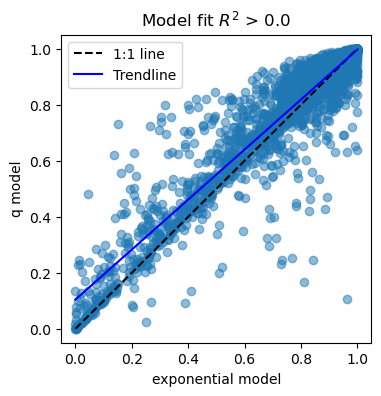

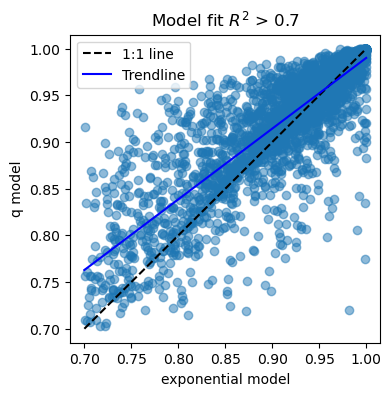

In [123]:
def plot_R2_models(R2_threshold):
    # Assuming you have a DataFrame named 'df' with columns 'exp_r_squared' and 'q_r_squared'
    # Replace 'df' with your actual DataFrame name

    x = df['exp_r_squared'].values
    y = df['q_r_squared'].values
    success_fit_idx = (x > R2_threshold) & (y > R2_threshold)

    # Create a scatter plot
    plt.figure(figsize=(4, 4))
    plt.scatter(x[success_fit_idx], y[success_fit_idx], alpha=0.5)  # alpha controls point transparency
    plt.title(f'Model fit $R^2$ > {R2_threshold}')
    plt.xlabel('exponential model')
    plt.ylabel('q model')
    plt.ylabel

    # Set the x and y-axis limits to the range [0.8, 1]
    plt.plot([R2_threshold, 1], [R2_threshold, 1], color='k', linestyle='--', label='1:1 line')

    # Add a trendline
    coefficients = np.polyfit(x[success_fit_idx], y[success_fit_idx], 1)
    trendline_x = np.array([R2_threshold, 1])
    trendline_y = coefficients[0] * trendline_x + coefficients[1]
    plt.plot(trendline_x, trendline_y, color='blue', label='Trendline')
    plt.legend()

plot_R2_models(R2_threshold=0.0)
plot_R2_models(R2_threshold=0.7)

# Plot longitudinal distribution (lat,lon)

In [90]:
filtered_df = df[df['q_r_squared'] >= 0.7]

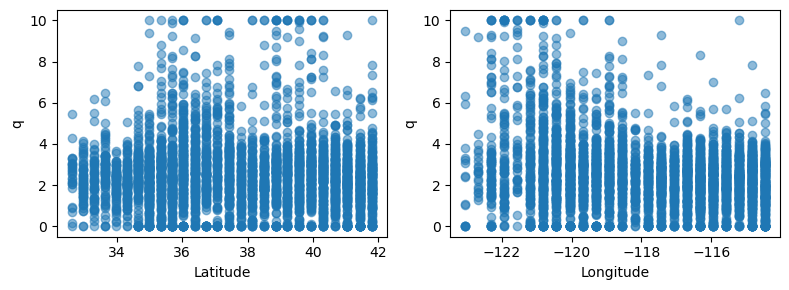

In [127]:
def plot_param_distribution(df=None, model_type=None, parameter=None):

    varname = f"{model_type}_{parameter}"
    # Create a figure and a 1x2 grid of subplots
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))

    # Scatter plot for latitude vs. q
    axs[0].scatter(df['latitude'], df[varname], alpha=0.5)
    axs[0].set_xlabel('Latitude')
    axs[0].set_ylabel(f'{parameter}')

    # Scatter plot for longitude vs. q
    axs[1].scatter(df['longitude'], df[varname], alpha=0.5)
    axs[1].set_xlabel('Longitude')
    axs[1].set_ylabel(f'{parameter}')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_param_distribution(df=filtered_df, model_type="q", parameter="q")

In [95]:
filtered_df_expon = df[df['exp_r_squared'] >= 0.7]

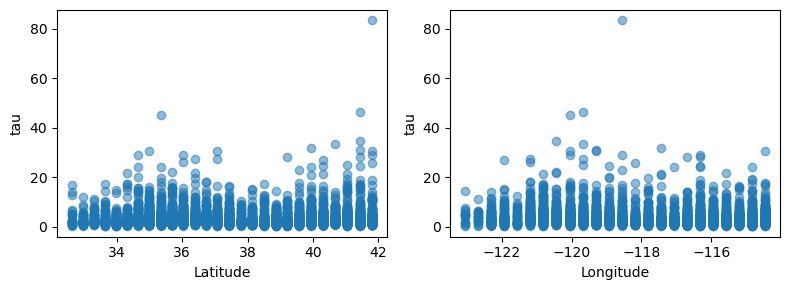

In [128]:
plot_param_distribution(df=filtered_df, model_type="exp", parameter="tau")

# Plot in map

In [134]:
def create_mean_dataarray(df=None, model_type=None, parameter=None):
    varname = f"{model_type}_{parameter}"
    mean_values = filtered_df.groupby(['latitude', 'longitude'])[varname].mean()
    data_array = mean_values.reset_index().pivot(index='latitude', columns='longitude', values=varname)
    return data_array

In [136]:
def plot_map(data_array=None, parameter=None, norm=None):
    # Create a figure and axes with Cartopy projection
    fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})

    # Create a grid of lat and lon coordinates
    lons, lats = np.meshgrid(data_array.columns, data_array.index)
    # Plot the heatmap using Cartopy
    im = ax.pcolormesh(lons, lats, data_array.values, norm=norm, cmap='BrBG', transform=ccrs.PlateCarree(),) #, vmin=vmin, vmax=vmax)

    # Add coastlines
    ax.coastlines()

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', label=f'Mean {parameter}')

    # Set plot title and labels
    ax.set_title(f'Mean {parameter} per pixel (California)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    plt.show()
    plt.tight_layout()

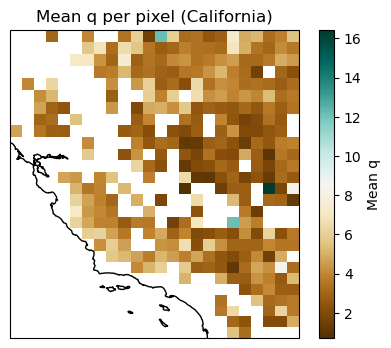

<Figure size 640x480 with 0 Axes>

In [137]:
da_q = create_mean_dataarray(df=filtered_df, model_type="exp", parameter="tau")
plot_map(data_array=da_q, parameter="q")
norm = TwoSlopeNorm(vmin=vmin, vcenter=midpoint, vmax=vmax)
plot_map(data_array=da_q, parameter="q", norm=norm)

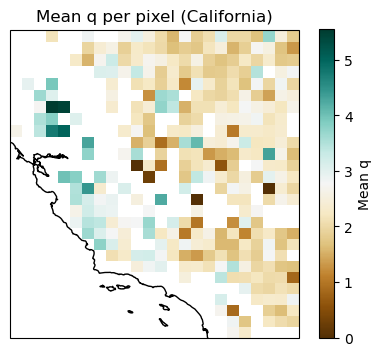

<Figure size 640x480 with 0 Axes>

In [114]:
# Create a figure and axes with Cartopy projection
fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})

# Create a grid of lat and lon coordinates
lons, lats = np.meshgrid(data_array.columns, data_array.index)

# vmin = 0
# vmax = 8
# midpoint = 1.0
# norm = TwoSlopeNorm(vmin=vmin, vcenter=midpoint, vmax=vmax)
# Plot the heatmap using Cartopy
im = ax.pcolormesh(lons, lats, data_array.values, cmap='BrBG', transform=ccrs.PlateCarree(),) #, vmin=vmin, vmax=vmax)

# Add coastlines
ax.coastlines()

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', label='Mean q')

# Set plot title and labels
ax.set_title('Mean q per pixel (California)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()
plt.tight_layout()

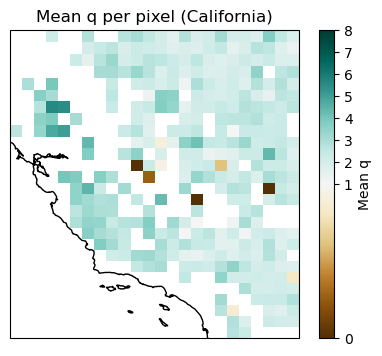

<Figure size 640x480 with 0 Axes>

In [85]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
from matplotlib.colors import TwoSlopeNorm 
# Create a figure and axes with Cartopy projection
fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})

# Create a grid of lat and lon coordinates
lons, lats = np.meshgrid(data_array.columns, data_array.index)

vmin = 0
vmax = 8
midpoint = 1.0
norm = TwoSlopeNorm(vmin=vmin, vcenter=midpoint, vmax=vmax)
# Plot the heatmap using Cartopy
im = ax.pcolormesh(lons, lats, data_array.values,  norm=norm, cmap='BrBG', transform=ccrs.PlateCarree(),) #, vmin=vmin, vmax=vmax)

# Add coastlines
ax.coastlines()

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', label='Mean q')

# Set plot title and labels
ax.set_title('Mean q per pixel (California)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()
plt.tight_layout()

In [99]:
tau_mean_values = filtered_df_expon.groupby(['latitude', 'longitude'])['exp_tau'].mean()
tau_mean_values.head()

latitude   longitude  
32.621510  -116.327805    5.469588
           -115.954350    3.380745
32.956165  -116.327805    3.038925
           -115.954350    2.401600
           -115.207466    2.114428
Name: exp_tau, dtype: float64

In [100]:
# Create an xarray DataArray using the pivot method
da_tau = tau_mean_values.reset_index().pivot(index='latitude', columns='longitude', values='exp_tau')
da_tau

longitude,-123.049790,-122.676346,-122.302900,-121.929460,-121.556015,-121.182570,-120.809130,-120.435684,-120.062240,-119.688800,...,-117.821580,-117.448135,-117.074690,-116.701250,-116.327805,-115.954350,-115.580910,-115.207466,-114.834020,-114.460580
latitude,,,,,,,,,,,,,,,,,,,,,
32.621510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.469588,3.380745,NaN,NaN,NaN,NaN
32.956165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.038925,2.401600,NaN,2.114428,2.113185,4.933250
33.292070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.560019,6.377052,NaN,NaN,2.952509,5.144008,3.671401
33.629246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.376220,NaN,NaN,5.441896,2.980355,2.564467,3.657825
33.967724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.347623,3.033765,3.473214,2.874601,2.700051
34.307530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.458228,NaN,NaN,3.208087,2.745754,2.769059,4.277784,3.837594,2.610837,5.258596
34.648690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.776374,2.749755,2.892736,3.064248,1.086814,1.585868,4.770557,4.479596,8.341519,3.274293
34.991234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.475698,5.204784,...,3.789252,4.706941,3.330119,2.274406,2.015632,2.801189,1.605747,1.559495,4.147002,NaN
35.335194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.270028,4.689412,4.039431,...,6.714707,2.660268,5.470568,4.241746,2.954255,2.973657,2.978910,4.976825,3.739827,3.517199


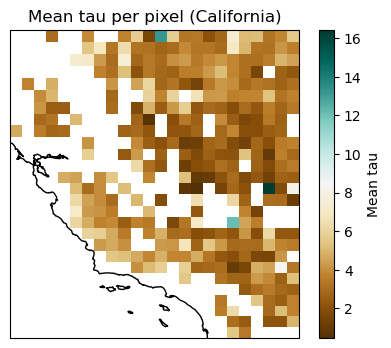

<Figure size 640x480 with 0 Axes>

In [115]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
from matplotlib.colors import TwoSlopeNorm 

# Create a figure and axes with Cartopy projection
fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})

# Create a grid of lat and lon coordinates
lons, lats = np.meshgrid(da_tau.columns, da_tau.index)

# vmin = 0
# vmax = 8
# # midpoint = 4
# norm = TwoSlopeNorm(vmin=vmin, vcenter=midpoint, vmax=vmax)
# Plot the heatmap using Cartopy
im = ax.pcolormesh(lons, lats, da_tau.values,  cmap='BrBG', transform=ccrs.PlateCarree()) #, vmin=vmin, vmax=vmax)

# Add coastlines
ax.coastlines()

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', label='Mean tau')

# Set plot title and labels
ax.set_title('Mean tau per pixel (California)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()
plt.tight_layout()

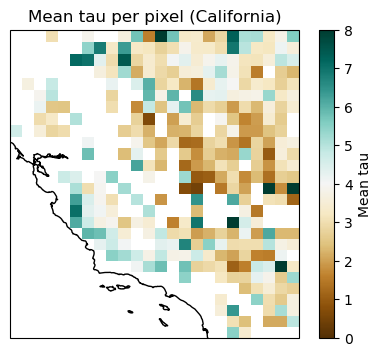

<Figure size 640x480 with 0 Axes>

In [113]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
from matplotlib.colors import TwoSlopeNorm 
# Create a figure and axes with Cartopy projection
fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})

# Create a grid of lat and lon coordinates
lons, lats = np.meshgrid(da_tau.columns, da_tau.index)

vmin = 0
vmax = 8
# midpoint = 4
# norm = TwoSlopeNorm(vmin=vmin, vcenter=midpoint, vmax=vmax)
# Plot the heatmap using Cartopy
im = ax.pcolormesh(lons, lats, da_tau.values,  cmap='BrBG', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)

# Add coastlines
ax.coastlines()

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', label='Mean tau')

# Set plot title and labels
ax.set_title('Mean tau per pixel (California)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()
plt.tight_layout()

In [121]:
filtered_df["AET/PET"] = filterd_df["q_k"]/filtered_df["PET"]
mean_values = filtered_df.groupby(['latitude', 'longitude'])["AET/PET"].mean()
mean_values.head()

NameError: name 'filterd_df' is not defined